In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
import time
import pandas as pd
import shutil

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

from google.colab import drive
drive.mount('/content/drive')
from drive.MyDrive.common.Common import NeuralNet

Mounted at /content/drive


In [2]:
from google.colab import files
uploaded = files.upload()

Saving TestingData.txt to TestingData.txt


In [3]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_, constants):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        # Initialise constants for PDE
        self.alphf = constants[0]
        self.hf = constants[1]
        self.Th = constants[2]
        self.Uf = constants[3]
        self.alphs = constants[4]
        self.hs = constants[5]
        self.T0 = constants[6]

        # initialise domain
        self.domain_extrema = torch.tensor([[0, 1],  # Time dimension
                                            [0, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_T = 2.5

        # F Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=2,
                                              n_hidden_layers=5,
                                              neurons=30,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition T=T0
    def initial_condition(self):
        return self.T0*torch.ones((self.n_tb, 2))

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_condition()

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.zeros((input_sb.shape[0], 2))
        output_sb_L = torch.zeros((input_sb.shape[0], 2))

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        T_pred_tb = self.approximate_solution(input_tb)
        return T_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        T_pred_sb = self.approximate_solution(input_sb)
        return T_pred_sb


    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        T = self.approximate_solution(input_int)

        T_f = T[:,0]
        T_s = T[:,1]

        grad_T_f = torch.autograd.grad(T_f.sum(), input_int, create_graph=True)[0]
        grad_T_s = torch.autograd.grad(T_s.sum(), input_int, create_graph=True)[0]

        grad_T_f_t = grad_T_f[:, 0]
        grad_T_s_t = grad_T_s[:, 0]
        grad_T_f_x = grad_T_f[:, 1]
        grad_T_s_x = grad_T_s[:, 1]
        grad_T_f_xx = torch.autograd.grad(grad_T_f_x.sum(), input_int, create_graph=True)[0][:, 1]
        grad_T_s_xx = torch.autograd.grad(grad_T_s_x.sum(), input_int, create_graph=True)[0][:, 1]

        # residual to enforce underlying pde
        residual_f = grad_T_f_t + self.Uf * grad_T_f_x - self.alphf * grad_T_f_xx + self.hf * (T_f - T_s)
        residual_s = grad_T_s_t - self.alphs * grad_T_s_xx - self.hs * (T_f - T_s)

        return residual_f.reshape(-1, ), residual_s.reshape(-1, )

    def compute_sb_residual(self, input_sb):
        input_sb.requires_grad = True
        T_sb = self.approximate_solution(input_sb)
        T_sb_f = T_sb[:,0]
        T_sb_s = T_sb[:,1]

        grad_T_x_sb_f = torch.autograd.grad(T_sb_f.sum(), input_sb, create_graph=True, allow_unused=True)[0][:, 1]
        grad_T_x_sb_s = torch.autograd.grad(T_sb_s.sum(), input_sb, create_graph=True, allow_unused=True)[0][:, 1]

        residual_f_0 = T_sb_f[:self.n_sb] - (self.Th - self.T0)/(1+torch.exp(-200*(input_sb[:self.n_sb, 0] - 0.25))) - self.T0

        residual_f_1 = grad_T_x_sb_f[self.n_sb:].reshape(-1, )
        residual_s_0 = grad_T_x_sb_s[:self.n_sb].reshape(-1, )
        residual_s_1 = grad_T_x_sb_s[self.n_sb:].reshape(-1, )

        return residual_f_0, residual_f_1, residual_s_0, residual_s_1

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)

        r_int_f, r_int_s = self.compute_pde_residual(inp_train_int)

        r_sb_f_0, r_sb_f_1, r_sb_s_0, r_sb_s_1 = self.compute_sb_residual(inp_train_sb)

        r_tb_f = u_train_tb[:,0] - u_pred_tb[:,0]
        r_tb_s = u_train_tb[:,1] - u_pred_tb[:,1]

        loss_int_f = torch.mean(abs(r_int_f)**2)
        loss_int_s = torch.mean(abs(r_int_s)**2)
        loss_sb_f_0 = torch.mean(abs(r_sb_f_0)**2)
        loss_sb_f_1 = torch.mean(abs(r_sb_f_1)**2)
        loss_sb_s_0 = torch.mean(abs(r_sb_s_0)**2)
        loss_sb_s_1 = torch.mean(abs(r_sb_s_1)**2)
        loss_tb_f = torch.mean(abs(r_tb_f)**2)
        loss_tb_s = torch.mean(abs(r_tb_s)**2)

        loss_f = loss_sb_f_0 + loss_sb_f_1 + loss_tb_f
        loss_s = loss_sb_s_0 + loss_sb_s_1 + loss_tb_s
        loss_int = loss_int_f + loss_int_s

        loss = torch.log10(self.lambda_T * (loss_s + loss_f) + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_f + loss_s).item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True, verbose_red=False):
        history = list()

        # verbose_red is for reduced printing every 100 epochs
        # Loop over epochs
        for epoch in range(num_epochs):
            if epoch%100==0:
                if verbose_red: print("################################ ", epoch, " ################################")

            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    ################################################################################################
    def plotting(self):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)

        output = self.approximate_solution(inputs)

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output[:,0].detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output[:,1].detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("F")
        axs[1].set_title("S")

        plt.show()

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Total loss:  -2.8529 | PDE Loss:  -4.2025 | Function Loss:  -2.9044
Total loss:  -2.8537 | PDE Loss:  -4.2057 | Function Loss:  -2.9048
Total loss:  -2.8545 | PDE Loss:  -4.2076 | Function Loss:  -2.9055
Total loss:  -2.8554 | PDE Loss:  -4.2109 | Function Loss:  -2.9061
Total loss:  -2.8561 | PDE Loss:  -4.2107 | Function Loss:  -2.907
Total loss:  -2.8569 | PDE Loss:  -4.2096 | Function Loss:  -2.908
Total loss:  -2.8578 | PDE Loss:  -4.2084 | Function Loss:  -2.9091
Total loss:  -2.8585 | PDE Loss:  -4.2004 | Function Loss:  -2.911
Total loss:  -2.8593 | PDE Loss:  -4.2011 | Function Loss:  -2.9117
Total loss:  -2.8602 | PDE Loss:  -4.202 | Function Loss:  -2.9126
Total loss:  -2.8611 | PDE Loss:  -4.2017 | Function Loss:  -2.9137
Total loss:  -2.8619 | PDE Loss:  -4.2017 | Function Loss:  -2.9146
Total loss:  -2.8626 | PDE Loss:  -4.2018 | Function Loss:  -2.9154
Total loss:  -2.8632 | PDE Loss:  -4.2009 | Function 

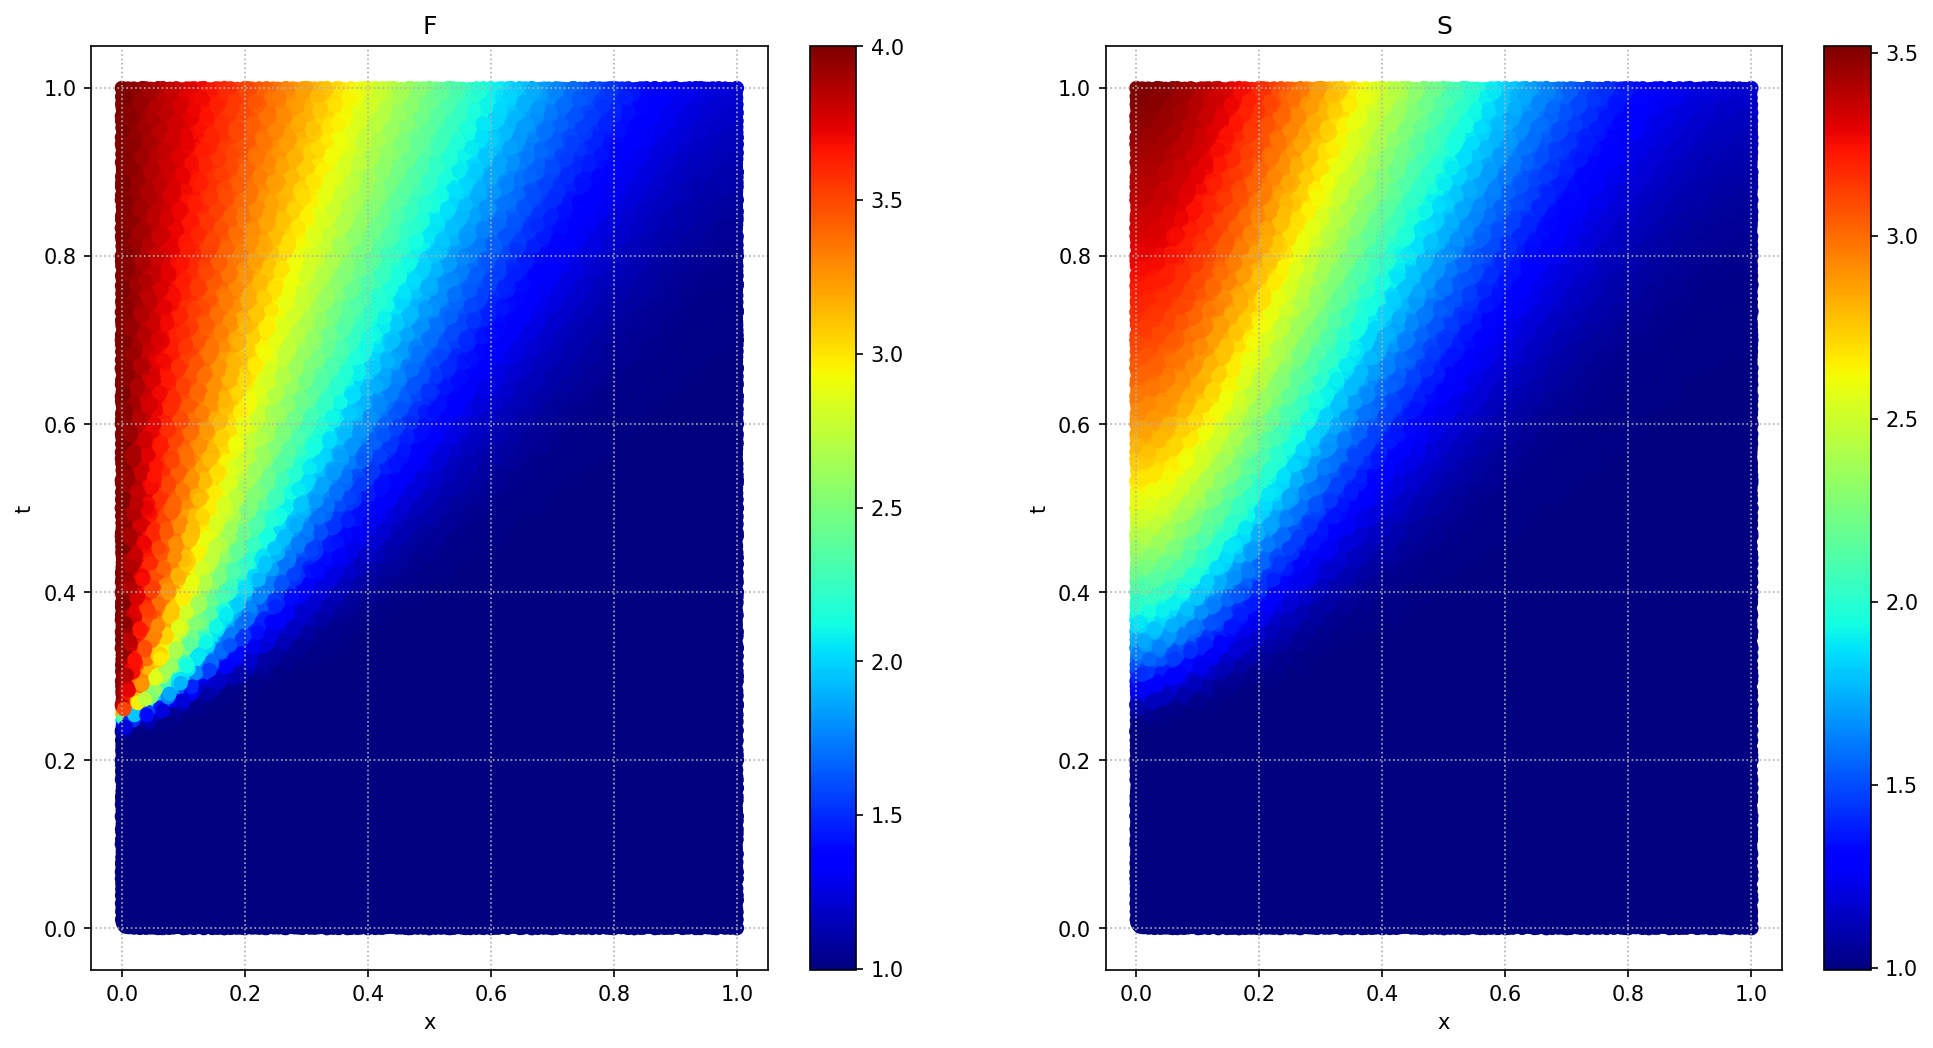

'/content/drive/My Drive/Colab Notebooks/task1_lam2.5_5layer_30N.txt'

In [ ]:
n_int = 256*2
n_sb = 64*2
n_tb = 64*2
constants = np.array([0.05, 5., 4., 1., 0.08, 6., 1.])

weight_decay = 0

pinn = Pinns(n_int, n_sb, n_tb, constants)

optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                            lr=float(0.5),
                            max_iter=50000,
                            max_eval=50000,
                            history_size=150,
                            line_search_fn="strong_wolfe",
                            tolerance_change=1.0 * np.finfo(float).eps)

optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.001), weight_decay=weight_decay)

n_epochs_adam = 1000
n_epochs_lbfgs = 2

hist_adam = pinn.fit(num_epochs=n_epochs_adam,
                optimizer=optimizer_ADAM,
                verbose=False, verbose_red=True)

hist_lbfgs = pinn.fit(num_epochs=n_epochs_lbfgs,
                optimizer=optimizer_LBFGS,
                verbose=True, verbose_red=False)

pinn.plotting()

df = pd.read_csv('TestingData.txt')
test_pts = torch.tensor(df[['t', 'x']].values, dtype=torch.float)

output_pred= pinn.approximate_solution(test_pts).to('cpu')
test_pts= test_pts.to('cpu')

sub_df = pd.DataFrame({'t': test_pts[:,0].detach().cpu().numpy() , 'x': test_pts[:,1].detach().cpu().numpy(), 'tf': output_pred[:,0].detach().cpu().numpy(), 'ts': output_pred[:,1].detach().cpu().numpy()})
sub_df.to_csv('task1_lam2.5_5layer_30N.txt', index=False)

destination_folder = '/content/drive/My Drive/Colab Notebooks/'
shutil.move('task1_lam2.5_5layer_30N.txt', destination_folder + 'task1_lam2.5_5layer_30N.txt')
